## Demo 2: Gaussian linear regression

Today, we will develop some intuition about using Bayesian inference to do linear regression, perform predictions, and judge model performance. We focus only on the Gaussian likelihood and Gaussian prior.


### Goals:
1. Learn how Bayesian linear model to fit data and do error estimates 
2. Learn how different priors in the model can regularize its behavior

### Highlights:
* The theory part of today's DEMO is based on Murphy's 15.2.
* Murphy's 15.2.4 contains an example of how to choose a plausible informative prior. Spoiler: Use prior predictive distribution.
* This DEMO is based on scikit-learn's [documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ard.html) about "Comparing Linear Bayesian Regressors." (see also [Bayesian Regression user guide](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression))


### Further reading:
* Automatic relevancy determination -- check out [this scikit-learn doc](https://scikit-learn.org/stable/modules/linear_model.html#automatic-relevance-determination) or Murphy's 15.2.8.
* Other than the ridge regularization introduced here, we can also use priors to induce sparsity (i.e., certain learned coefficients become exactly zero). Please check out Murphy's 15.2.5-15.2.7 for that. 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["lines.linewidth"] = 2
plt.rcParams.update({"font.size": 14})

import seaborn as sns

In [2]:
DATA_RANGE = 10
rng = np.random.RandomState(0)

# 🕹️; if TRUE, also show ARD or OLS regressors
# ARD = True
ARD = False
OLS = True
# OLS = False


# 🕹️; try n >= 1
n_samples = 100

# sort the data to make plotting easier later
# X is a sorted random variable along 0 to 10
X = np.sort(-DATA_RANGE * rng.rand(n_samples) + DATA_RANGE)

# 🕹️; add some noise...
sigma = 100  # try 1, 10, or 100
noise = rng.normal(0, sigma, n_samples) * 1.35

# 🕹️; try to use your own regression model
# Make sure your model is defined when x < 0.
# model = lambda x: x  # Example model 1
# model = lambda x: np.sin(x)  # Example model 2
model = lambda x: x**3 + x**1  # Example model 3

# model = lambda x: np.square(x) * np.sin(x)


# DO NOT MODIFY #
y = model(X) + noise
full_data = pd.DataFrame({"input_feature": X, "target": y})
X = X.reshape((-1, 1))

# We append some "correct data" (without noise)
# to the beginning and end of the noisy data,
# in hope to see how the learned model predicts
X_plot_post = np.linspace(DATA_RANGE, DATA_RANGE + 0.5, 5)
X_plot_pre = np.linspace(-0.5, 0, 5)
y_plot_post = model(X_plot_post)
y_plot_pre = model(X_plot_pre)

X_plot = np.concatenate((X, X_plot_post.reshape((-1, 1))))
X_plot = np.concatenate((X_plot_pre.reshape((-1, 1)), X_plot))
y_plot = np.concatenate((y - noise, y_plot_post))
y_plot = np.concatenate((y_plot_pre, y_plot))

In [3]:
# Note that we do not feed the model with the extended "correct data"
# 🕹️; change the degree of the polynomial regression
degree = 2

# 🕹️; change the shape parameter of Gamma distr. on the weights
lambda_1 = 1e-6  # default
# lambda_1 = 1e-1

brr_poly = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=True),
    StandardScaler(),
    BayesianRidge(lambda_1=lambda_1),
).fit(X, y)
y_brr, y_brr_std = brr_poly.predict(X_plot, return_std=True)

if OLS:
    lin_poly = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=True),
        StandardScaler(),
        LinearRegression(),
    ).fit(X, y)
    y_lin = lin_poly.predict(X_plot)

if ARD:
    ard_poly = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=True),
        StandardScaler(),
        ARDRegression(),
    ).fit(X, y)
    y_ard, y_ard_std = ard_poly.predict(X_plot, return_std=True)

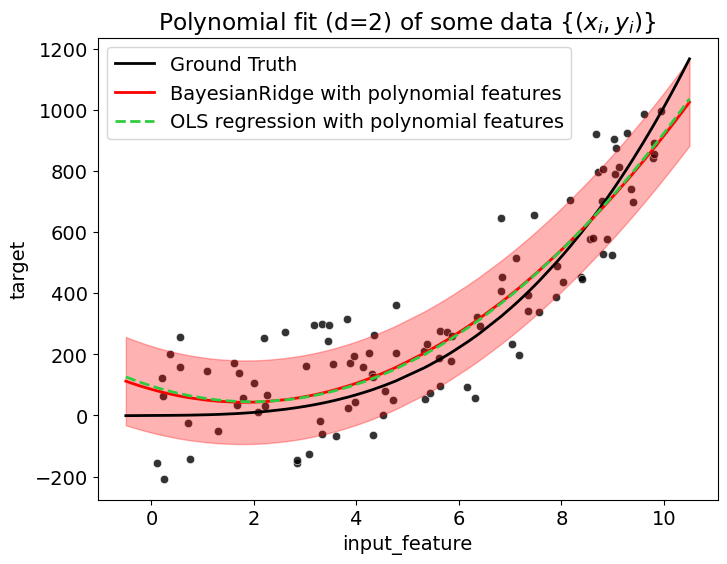

In [4]:
ax = sns.scatterplot(
    data=full_data, x="input_feature", y="target", color="black", alpha=0.8
)

# Instead of '-', we can try 'o-' and see the actual data points
ax.plot(
    X_plot, y_plot, "-", color="black", label="Ground Truth", markerfacecolor="none"
)

ax.plot(X_plot, y_brr, color="red", label="BayesianRidge with polynomial features")
ax.fill_between(
    X_plot.ravel(),
    y_brr - y_brr_std,
    y_brr + y_brr_std,
    color="red",
    alpha=0.3,
)

if ARD:
    ax.plot(X_plot, y_ard, color="navy", label="ARD with polynomial features")
    ax.fill_between(
        X_plot.ravel(),
        y_ard - y_ard_std,
        y_ard + y_ard_std,
        color="navy",
        alpha=0.3,
    )

if OLS:
    ax.plot(
        X_plot,
        y_lin,
        "--",
        color="#2ECC40",
        label="OLS regression with polynomial features",
    )

ax.legend()
_ = ax.set_title(f"Polynomial fit (d={degree}) of some data " + "$\{(x_i, y_i)\}$")

### Here is a number of things to try
* More data, less prediction uncertainty  
Use `Model 1`, `d=1`, try `n_samples = 1`, `n_samples = 10` vs. `n_samples = 100`.

* Learn that OLS estimate is very similar to Gaussian MAP estimate  
Use `OLS = True`, `Model 3`, `d=2`, try `n_samples = 10` vs. `n_samples = 100`.

* Try play around `lambda_1` a bit, can we control the uncertainty of the fit?

* ARD has a better control over model complexity than BayesianRidge  
Use `ARD = True`, `n_samples = 10`, `use Model 1`, & `d = 3`.


